In [1]:
from datasets import load_dataset
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
import spacy
import torch
import evaluate
from tqdm import tqdm
import re

# 加載 IWSLT 2017 英中翻譯資料集的驗證和測試集
val_dataset = load_dataset('iwslt2017', 'iwslt2017-en-zh', split='validation[:10]', trust_remote_code=True)
# test_dataset = load_dataset('iwslt2017', 'iwslt2017-en-zh', split='test[:10]', trust_remote_code=True)

# 加載微調後的模型和 tokenizer
model = MBartForConditionalGeneration.from_pretrained("./Weight/mbart_finetuned")
tokenizer = MBart50Tokenizer.from_pretrained("./Weight/mbart_finetuned")


# 設置源語言和目標語言
tokenizer.src_lang = "en_XX"
model.config.forced_bos_token_id = tokenizer.lang_code_to_id["zh_CN"]

# 加載 SpaCy 英文 NER 模型
nlp = spacy.load("en_core_web_sm")

# METEOR 評估指標
meteor_metric = evaluate.load("meteor")

# 步驟 1：實體標記和替換
def mark_entities(text):
    doc = nlp(text)
    modified_text = text
    entities = []
    for ent in doc.ents:
        entity_marker = f"<<{ent.label_}:{ent.text}>>"
        modified_text = modified_text.replace(ent.text, entity_marker)
        entities.append((ent.text, ent.label_))
    return modified_text, entities


# 步驟 2：翻譯帶有實體標記的句子，加入打印語句
def translate_with_entities(text, max_length=80, length_penalty=1.2, num_beams=5):
    marked_text, entities = mark_entities(text)
    print("Original Text:", text)
    print("")
    print("Marked Text:", marked_text)
    print("Entities:", entities)
    print("")
    inputs = tokenizer(marked_text, return_tensors="pt")
    translated_tokens = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        length_penalty=length_penalty,
        num_beams=num_beams,
        forced_bos_token_id=tokenizer.lang_code_to_id["zh_CN"]
    )
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    print("Translated Text:", translated_text)
    # print("="*50)  # 分隔線便於區分不同句子的輸出

    return translated_text, entities

# 步驟 3：後處理還原實體
def postprocess_translation(translated_text, entities):
    for ent_text, ent_label in entities:
        # 使用正則表達式來匹配標記，無論模型是否對標記進行了部分修改
        entity_marker_pattern = re.escape(f"<<{ent_label}:") + r"(.*?)>>"
        translated_text = re.sub(entity_marker_pattern, ent_text, translated_text)
    return translated_text


# 完整的 Entity-Aware 翻譯函數
def entity_aware_translate(text):
    translated_text, entities = translate_with_entities(text)
    final_translation = postprocess_translation(translated_text, entities)
    return final_translation


# 評估 METEOR 分數
def compute_meteor(predictions, references):
    meteor_metric.add_batch(predictions=predictions, references=references)
    result = meteor_metric.compute()
    return result

# 在驗證集上進行翻譯並計算 METEOR 分數
print("Evaluating on Validation Set...")
val_predictions = []
val_references = []
for example in tqdm(val_dataset, desc="Processing Validation Set"):
    input_text = example["translation"]["en"]
    reference_text = example["translation"]["zh"]
    final_translation = entity_aware_translate(input_text)
    print("Reference Text:", reference_text)
    print("Translated Text:", final_translation)
    print("=" * 50)
    val_predictions.append(final_translation)
    val_references.append([reference_text])  # METEOR 要求 reference 為列表

val_meteor_score = compute_meteor(val_predictions, val_references)
print("Validation Set METEOR score:", val_meteor_score)



C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluating on Validation Set...


Processing Validation Set:   0%|                                                                | 0/10 [00:00<?, ?it/s]C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\transformers\generation\utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Original Text: Last year I showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent.

Marked Text: <<DATE:Last year>> I showed these <<CARDINAL:two>> slides so that  demonstrate that <<LOC:the arctic ice cap>>,  which for most of <<DATE:the last three million years>>  has been the size of the lower <<CARDINAL:48>> states,  has shrunk by <<PERCENT:40 percent>>.
Entities: [('Last year', 'DATE'), ('two', 'CARDINAL'), ('the arctic ice cap', 'LOC'), ('the last three million years', 'DATE'), ('48', 'CARDINAL'), ('40 percent', 'PERCENT')]



Processing Validation Set:  10%|█████▌                                                  | 1/10 [00:09<01:25,  9.46s/it]

Translated Text: “DATE:去年” 我展示了这两张“大陆”幻灯片, 说明着“洛克:北极的冰盖” 在“Date:过去300万年”大部分时间里都是 较小的“大陆48” 的大小, 缩小了40%。
Reference Text: 去年我给各位展示了两个 关于北极冰帽的演示 在过去三百万年中 其面积由相当于美国南方48州面积总和 缩减了40%
Translated Text: “DATE:去年” 我展示了这两张“大陆”幻灯片, 说明着“洛克:北极的冰盖” 在“Date:过去300万年”大部分时间里都是 较小的“大陆48” 的大小, 缩小了40%。
Original Text: But this understates the seriousness of this particular problem  because it doesn't show the thickness of the ice.

Marked Text: But this understates the seriousness of this particular problem  because it doesn't show the thickness of the ice.
Entities: []



Processing Validation Set:  20%|███████████▏                                            | 2/10 [00:11<00:41,  5.17s/it]

Translated Text: 但这不足以说明这个问题的严重性, 因为它没有显示冰的厚度。
Reference Text: 但这些没能完全说明这个问题的严重性 因为这没有表示出冰帽的厚度
Translated Text: 但这不足以说明这个问题的严重性, 因为它没有显示冰的厚度。
Original Text: The arctic ice cap is, in a sense,  the beating heart of the global climate system.

Marked Text: The arctic ice cap is, in a sense,  the beating heart of the global climate system.
Entities: []



Processing Validation Set:  30%|████████████████▊                                       | 3/10 [00:14<00:27,  3.91s/it]

Translated Text: 北极的冰盖,在某种意义上, 是全球气候系统的活跃中心。
Reference Text: 感觉上，北极冰帽 就好象全球气候系统中跳动的心脏
Translated Text: 北极的冰盖,在某种意义上, 是全球气候系统的活跃中心。
Original Text: It expands in winter and contracts in summer.

Marked Text: It expands in <<DATE:winter>> and contracts in <<DATE:summer>>.
Entities: [('winter', 'DATE'), ('summer', 'DATE')]



Processing Validation Set:  40%|██████████████████████▍                                 | 4/10 [00:16<00:19,  3.29s/it]

Translated Text: 它在“DATE:冬天”中扩张, 然后在“DATE:夏天”中收缩。
Reference Text: 冬天心脏舒张，夏天心脏收缩
Translated Text: 它在“DATE:冬天”中扩张, 然后在“DATE:夏天”中收缩。
Original Text: The next slide I show you will be  a rapid fast-forward of what's happened over the last 25 years.

Marked Text: The next slide I show you will be  a rapid fast-forward of what's happened over <<DATE:the last 25 years>>.
Entities: [('the last 25 years', 'DATE')]



Processing Validation Set:  50%|████████████████████████████                            | 5/10 [00:24<00:24,  4.85s/it]

Translated Text: 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。
Reference Text: 下面我要展示的是 在过去25年里的极剧变化
Translated Text: 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。
Original Text: The permanent ice is marked in red.

Marked Text: The permanent ice is marked in red.
Entities: []



Processing Validation Set:  60%|█████████████████████████████████▌                      | 6/10 [00:25<00:14,  3.59s/it]

Translated Text: 永久的冰层以红色标记。
Reference Text: 红色的是永冻冰
Translated Text: 永久的冰层以红色标记。
Original Text: As you see, it expands to the dark blue --  that's the annual ice in winter,  and it contracts in summer.

Marked Text: As you see, it expands to the dark blue --  that's the annual ice in <<DATE:winter>>,  and it contracts in <<DATE:summer>>.
Entities: [('winter', 'DATE'), ('summer', 'DATE')]



Processing Validation Set:  70%|███████████████████████████████████████▏                | 7/10 [00:33<00:15,  5.02s/it]

Translated Text: 正如你所看到的,它变为深蓝色, 那是在“DATE:winter”中的年冰, 在“DATE:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的
Reference Text: 你看，它正在变成深蓝色 这是每年冬天形成的年度冰 在夏天永冻冰收缩
Translated Text: 正如你所看到的,它变为深蓝色, 那是在“DATE:winter”中的年冰, 在“DATE:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的
Original Text: The so-called permanent ice, five years old or older,  you can see is almost like blood,  spilling out of the body here.

Marked Text: The so-called permanent ice, <<DATE:five years old>> or older,  you can see is almost like blood,  spilling out of the body here.
Entities: [('five years old', 'DATE')]



Processing Validation Set:  80%|████████████████████████████████████████████▊           | 8/10 [00:35<00:08,  4.27s/it]

Translated Text: 所谓永久的冰层,或更老的冰层, 你们能看到的几乎就像血一般 从我们的身体里冒出来。
Reference Text: 所谓的“永冻”，是指形成五年或更久的冰 你看，这也像血液一样 输送到身体各部位
Translated Text: 所谓永久的冰层,或更老的冰层, 你们能看到的几乎就像血一般 从我们的身体里冒出来。
Original Text: In 25 years it's gone from this, to this.

Marked Text: In <<DATE:25 years>> it's gone from this, to this.
Entities: [('25 years', 'DATE')]



Processing Validation Set:  90%|██████████████████████████████████████████████████▍     | 9/10 [00:37<00:03,  3.45s/it]

Translated Text: 在“DATE25年”里,它从这个变成了这个。
Reference Text: 在25年的时间里，它从这里，到了这里
Translated Text: 在“DATE25年”里,它从这个变成了这个。
Original Text: This is a problem because the warming  heats up the frozen ground around the Arctic Ocean,  where there is a massive amount of frozen carbon  which, when it thaws, is turned into methane by microbes.

Marked Text: This is a problem because the warming  heats up the frozen ground around <<LOC:the Arctic Ocean>>,  where there is a massive amount of frozen carbon  which, when it thaws, is turned into methane by microbes.
Entities: [('the Arctic Ocean', 'LOC')]



Processing Validation Set: 100%|███████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.21s/it]

Translated Text: 这是一个问题,因为全球变暖加剧了 北冰洋附近冰层的温度, 那里有大量的冰冻碳, 当它融化后,由微生物 转化为甲烷。
Reference Text: 值得注意的是 温室效应使得北冰洋周围的冻土层受热 而这里有大量被冻封的碳 解冻时，微生物降解碳形成甲烷
Translated Text: 这是一个问题,因为全球变暖加剧了 北冰洋附近冰层的温度, 那里有大量的冰冻碳, 当它融化后,由微生物 转化为甲烷。


Validation Set METEOR score: {'meteor': 0.005747126436781609}


In [7]:
# Enhanced Validation Function
def evaluate_model(val_dataset):
    val_predictions = []
    val_references = []
    entity_list = []
    
    for example in tqdm(val_dataset, desc="Processing Validation Set"):
        input_text = example["translation"]["en"]
        reference_text = example["translation"]["zh"]
        
        # Show original English text
        print("Original English Text:", input_text)
        
        # Translation with entities marked
        final_translation = entity_aware_translate(input_text)
        print("Reference Text:", reference_text)
        print("Translated Text:", final_translation)
        print("=" * 50)
        
        # Append translations and references
        val_predictions.append(final_translation)
        val_references.append([reference_text])
        _, entities = mark_entities(input_text)  # Get entities for preservation check
        entity_list.append(entities)
    
    # Calculate METEOR and BLEU scores
    val_meteor_score = meteor_metric.compute(predictions=val_predictions, references=val_references)
    val_bleu_score = bleu_metric.compute(predictions=val_predictions, references=val_references)
    
    # Calculate Entity Preservation Score
    entity_preservation_score = calculate_entity_preservation(val_predictions, val_references, entity_list)
    
    print("Validation Set METEOR score:", val_meteor_score)
    print("Validation Set BLEU score:", val_bleu_score)
    print("Entity Preservation Score:", entity_preservation_score)

# Execute validation
evaluate_model(val_dataset)


Processing Validation Set:   0%|                                                                | 0/10 [00:00<?, ?it/s]

Original English Text: Last year I showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent.
Original Text: Last year I showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent.

Marked Text: <<DATE:Last year>> I showed these <<CARDINAL:two>> slides so that  demonstrate that <<LOC:the arctic ice cap>>,  which for most of <<DATE:the last three million years>>  has been the size of the lower <<CARDINAL:48>> states,  has shrunk by <<PERCENT:40 percent>>.
Entities: [('Last year', 'DATE'), ('two', 'CARDINAL'), ('the arctic ice cap', 'LOC'), ('the last three million years', 'DATE'), ('48', 'CARDINAL'), ('40 percent', 'PERCENT')]



Processing Validation Set:  10%|█████▌                                                  | 1/10 [00:05<00:51,  5.74s/it]

Translated Text: “DATE:去年” 我展示了这两张“大陆”幻灯片, 说明着“洛克:北极的冰盖” 在“Date:过去300万年”大部分时间里都是 较小的“大陆48” 的大小, 缩小了40%。
Reference Text: 去年我给各位展示了两个 关于北极冰帽的演示 在过去三百万年中 其面积由相当于美国南方48州面积总和 缩减了40%
Translated Text: “DATE:去年” 我展示了这两张“大陆”幻灯片, 说明着“洛克:北极的冰盖” 在“Date:过去300万年”大部分时间里都是 较小的“大陆48” 的大小, 缩小了40%。
Original English Text: But this understates the seriousness of this particular problem  because it doesn't show the thickness of the ice.
Original Text: But this understates the seriousness of this particular problem  because it doesn't show the thickness of the ice.

Marked Text: But this understates the seriousness of this particular problem  because it doesn't show the thickness of the ice.
Entities: []



Processing Validation Set:  20%|███████████▏                                            | 2/10 [00:07<00:26,  3.36s/it]

Translated Text: 但这不足以说明这个问题的严重性, 因为它没有显示冰的厚度。
Reference Text: 但这些没能完全说明这个问题的严重性 因为这没有表示出冰帽的厚度
Translated Text: 但这不足以说明这个问题的严重性, 因为它没有显示冰的厚度。
Original English Text: The arctic ice cap is, in a sense,  the beating heart of the global climate system.
Original Text: The arctic ice cap is, in a sense,  the beating heart of the global climate system.

Marked Text: The arctic ice cap is, in a sense,  the beating heart of the global climate system.
Entities: []



Processing Validation Set:  30%|████████████████▊                                       | 3/10 [00:09<00:18,  2.70s/it]

Translated Text: 北极的冰盖,在某种意义上, 是全球气候系统的活跃中心。
Reference Text: 感觉上，北极冰帽 就好象全球气候系统中跳动的心脏
Translated Text: 北极的冰盖,在某种意义上, 是全球气候系统的活跃中心。
Original English Text: It expands in winter and contracts in summer.
Original Text: It expands in winter and contracts in summer.

Marked Text: It expands in <<DATE:winter>> and contracts in <<DATE:summer>>.
Entities: [('winter', 'DATE'), ('summer', 'DATE')]



Processing Validation Set:  40%|██████████████████████▍                                 | 4/10 [00:11<00:14,  2.47s/it]

Translated Text: 它在“DATE:冬天”中扩张, 然后在“DATE:夏天”中收缩。
Reference Text: 冬天心脏舒张，夏天心脏收缩
Translated Text: 它在“DATE:冬天”中扩张, 然后在“DATE:夏天”中收缩。
Original English Text: The next slide I show you will be  a rapid fast-forward of what's happened over the last 25 years.
Original Text: The next slide I show you will be  a rapid fast-forward of what's happened over the last 25 years.

Marked Text: The next slide I show you will be  a rapid fast-forward of what's happened over <<DATE:the last 25 years>>.
Entities: [('the last 25 years', 'DATE')]



Processing Validation Set:  50%|████████████████████████████                            | 5/10 [00:17<00:19,  3.81s/it]

Translated Text: 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。
Reference Text: 下面我要展示的是 在过去25年里的极剧变化
Translated Text: 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。 下一张幻灯片是关于过去25年发生的事的快速进度。
Original English Text: The permanent ice is marked in red.
Original Text: The permanent ice is marked in red.

Marked Text: The permanent ice is marked in red.
Entities: []



Processing Validation Set:  60%|█████████████████████████████████▌                      | 6/10 [00:18<00:11,  2.88s/it]

Translated Text: 永久的冰层以红色标记。
Reference Text: 红色的是永冻冰
Translated Text: 永久的冰层以红色标记。
Original English Text: As you see, it expands to the dark blue --  that's the annual ice in winter,  and it contracts in summer.
Original Text: As you see, it expands to the dark blue --  that's the annual ice in winter,  and it contracts in summer.

Marked Text: As you see, it expands to the dark blue --  that's the annual ice in <<DATE:winter>>,  and it contracts in <<DATE:summer>>.
Entities: [('winter', 'DATE'), ('summer', 'DATE')]



Processing Validation Set:  70%|███████████████████████████████████████▏                | 7/10 [00:24<00:11,  3.94s/it]

Translated Text: 正如你所看到的,它变为深蓝色, 那是在“DATE:winter”中的年冰, 在“DATE:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的
Reference Text: 你看，它正在变成深蓝色 这是每年冬天形成的年度冰 在夏天永冻冰收缩
Translated Text: 正如你所看到的,它变为深蓝色, 那是在“DATE:winter”中的年冰, 在“DATE:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的年冰, 它在“Date:winter”中的
Original English Text: The so-called permanent ice, five years old or older,  you can see is almost like blood,  spilling out of the body here.
Original Text: The so-called permanent ice, five years old or older,  you can see is almost like blood,  spilling out of the body here.

Marked Text: The so-called permanent ice, <<DATE:five years old>> or older,  you can see is almost like blood,  spilling out of the body here.
Entities: [('five years old', 'DATE')]



Processing Validation Set:  80%|████████████████████████████████████████████▊           | 8/10 [00:27<00:06,  3.45s/it]

Translated Text: 所谓永久的冰层,或更老的冰层, 你们能看到的几乎就像血一般 从我们的身体里冒出来。
Reference Text: 所谓的“永冻”，是指形成五年或更久的冰 你看，这也像血液一样 输送到身体各部位
Translated Text: 所谓永久的冰层,或更老的冰层, 你们能看到的几乎就像血一般 从我们的身体里冒出来。
Original English Text: In 25 years it's gone from this, to this.
Original Text: In 25 years it's gone from this, to this.

Marked Text: In <<DATE:25 years>> it's gone from this, to this.
Entities: [('25 years', 'DATE')]



Processing Validation Set:  90%|██████████████████████████████████████████████████▍     | 9/10 [00:28<00:02,  2.81s/it]

Translated Text: 在“DATE25年”里,它从这个变成了这个。
Reference Text: 在25年的时间里，它从这里，到了这里
Translated Text: 在“DATE25年”里,它从这个变成了这个。
Original English Text: This is a problem because the warming  heats up the frozen ground around the Arctic Ocean,  where there is a massive amount of frozen carbon  which, when it thaws, is turned into methane by microbes.
Original Text: This is a problem because the warming  heats up the frozen ground around the Arctic Ocean,  where there is a massive amount of frozen carbon  which, when it thaws, is turned into methane by microbes.

Marked Text: This is a problem because the warming  heats up the frozen ground around <<LOC:the Arctic Ocean>>,  where there is a massive amount of frozen carbon  which, when it thaws, is turned into methane by microbes.
Entities: [('the Arctic Ocean', 'LOC')]



Processing Validation Set: 100%|███████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.29s/it]

Translated Text: 这是一个问题,因为全球变暖加剧了 北冰洋附近冰层的温度, 那里有大量的冰冻碳, 当它融化后,由微生物 转化为甲烷。
Reference Text: 值得注意的是 温室效应使得北冰洋周围的冻土层受热 而这里有大量被冻封的碳 解冻时，微生物降解碳形成甲烷
Translated Text: 这是一个问题,因为全球变暖加剧了 北冰洋附近冰层的温度, 那里有大量的冰冻碳, 当它融化后,由微生物 转化为甲烷。


NameError: name 'bleu_metric' is not defined

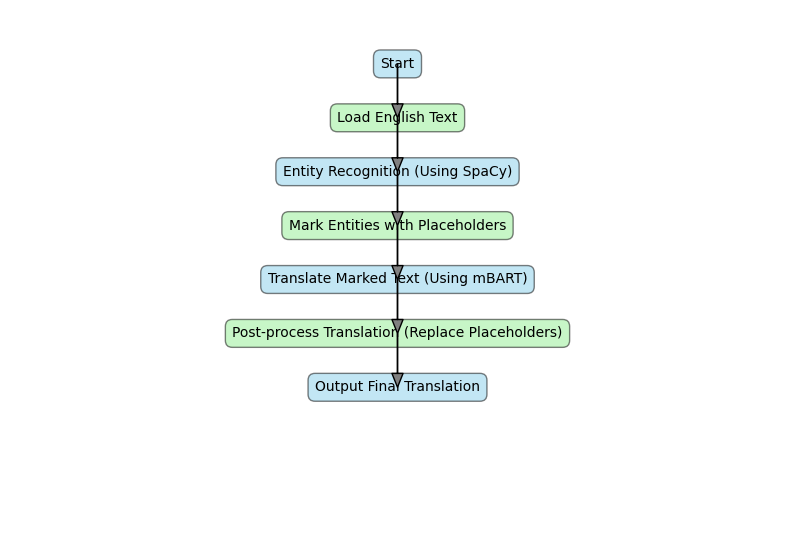

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.sankey import Sankey

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Define text for each step in the flowchart
texts = [
    "Start",
    "Load English Text",
    "Entity Recognition (Using SpaCy)",
    "Mark Entities with Placeholders",
    "Translate Marked Text (Using mBART)",
    "Post-process Translation (Replace Placeholders)",
    "Output Final Translation"
]

# Define the positions for each text box
positions = [
    (0.5, 0.9),  # Start
    (0.5, 0.8),  # Load English Text
    (0.5, 0.7),  # Entity Recognition (Using SpaCy)
    (0.5, 0.6),  # Mark Entities with Placeholders
    (0.5, 0.5),  # Translate Marked Text (Using mBART)
    (0.5, 0.4),  # Post-process Translation
    (0.5, 0.3)   # Output Final Translation
]

# Plot text boxes for each step
for i, (text, pos) in enumerate(zip(texts, positions)):
    ax.text(pos[0], pos[1], text, ha="center", va="center", 
            bbox=dict(facecolor="skyblue" if i % 2 == 0 else "lightgreen", alpha=0.5, boxstyle="round,pad=0.5"))

# Define arrows between steps
arrow_props = dict(facecolor='gray', edgecolor='black', width=0.005, headwidth=8, headlength=10)
for i in range(len(positions) - 1):
    start_pos = positions[i]
    end_pos = positions[i + 1]
    ax.annotate("", xy=end_pos, xytext=start_pos, arrowprops=arrow_props)

# Hide axes for clarity
ax.axis("off")

# Show the flowchart
plt.show()
